# N-HiTS 

In [1]:
!pip install darts

     -------------------------------------- 592.0/592.0 kB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 2.4 MB/s eta 0:00:00
     -------------------------------------- 208.5/208.5 kB 2.5 MB/s eta 0:00:00
     -------------------------------------- 571.9/571.9 kB 1.4 MB/s eta 0:00:00
     -------------------------------------- 147.7/147.7 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 74.0/74.0 MB 2.2 MB/s eta 0:00:00
     -------------------------------------- 973.1/973.1 kB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 89.1/89.1 MB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 12.1/12.1 MB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 43.8/43.8 kB 2.1 MB/s eta 0:00:00
     -------------------------------------- 435.6/435.6 kB 3.9 MB/s eta 0:00:00
     ---------------

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from darts import TimeSeries

import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tensorflow.keras.layers import MaxPool1D

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (9,6)

In [4]:
df = pd.read_csv('daily_traffic.csv')

df.head()

,date_time,traffic_volume
0,9/29/2016 17:00,5551.0
1,9/29/2016 18:00,4132.0
2,9/29/2016 19:00,3435.0
3,9/29/2016 20:00,2765.0
4,9/29/2016 21:00,2443.0


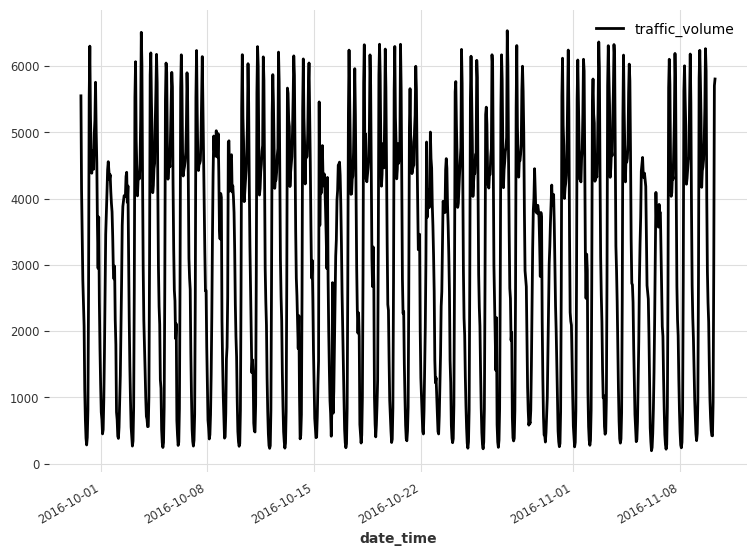

In [5]:
series = TimeSeries.from_dataframe(df, time_col='date_time')

series.plot()

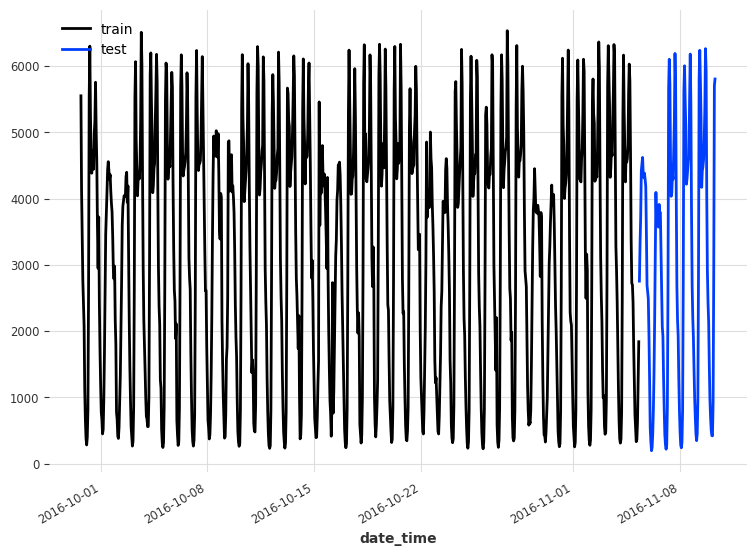

In [6]:
train, test = series[:-120], series[-120:]

train.plot(label='train')
test.plot(label='test')

## Baseline 

In [7]:
from darts.models.forecasting.baselines import NaiveSeasonal

naive_seasonal = NaiveSeasonal(K=168)
naive_seasonal.fit(train)

pred_naive = naive_seasonal.predict(120)

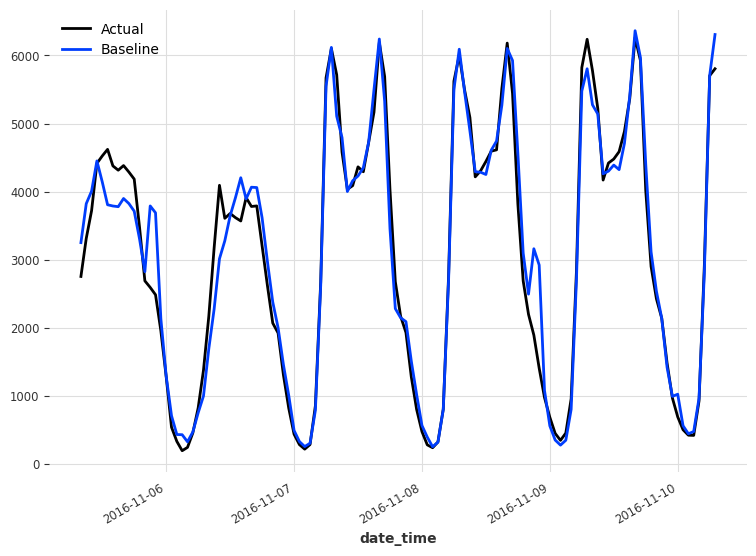

In [8]:
test.plot(label='Actual')
pred_naive.plot(label='Baseline')

In [11]:
from darts.metrics import mae, mape

# naive_mae = mae(test, pred_naive)
naive_mae = mape(test, pred_naive)

# print(naive_mae)
print(naive_mape)

NameError: name 'naive_mape' is not defined

### Demonstrate MaxPool

In [10]:
maxpool_l4 = MaxPool1D(pool_size=4, strides=1, padding='same')
maxpool_l12 = MaxPool1D(pool_size=12, strides=1, padding='same')
maxpool_l24 = MaxPool1D(pool_size=24, strides=1, padding='same')

x = df['traffic_volume'].values
x = tf.reshape(x, [1, len(x), 1])

x_maxpooled_l4 = maxpool_l4(x).numpy().flatten()
x_maxpooled_l12 = maxpool_l12(x).numpy().flatten()
x_maxpooled_l24 = maxpool_l24(x).numpy().flatten()


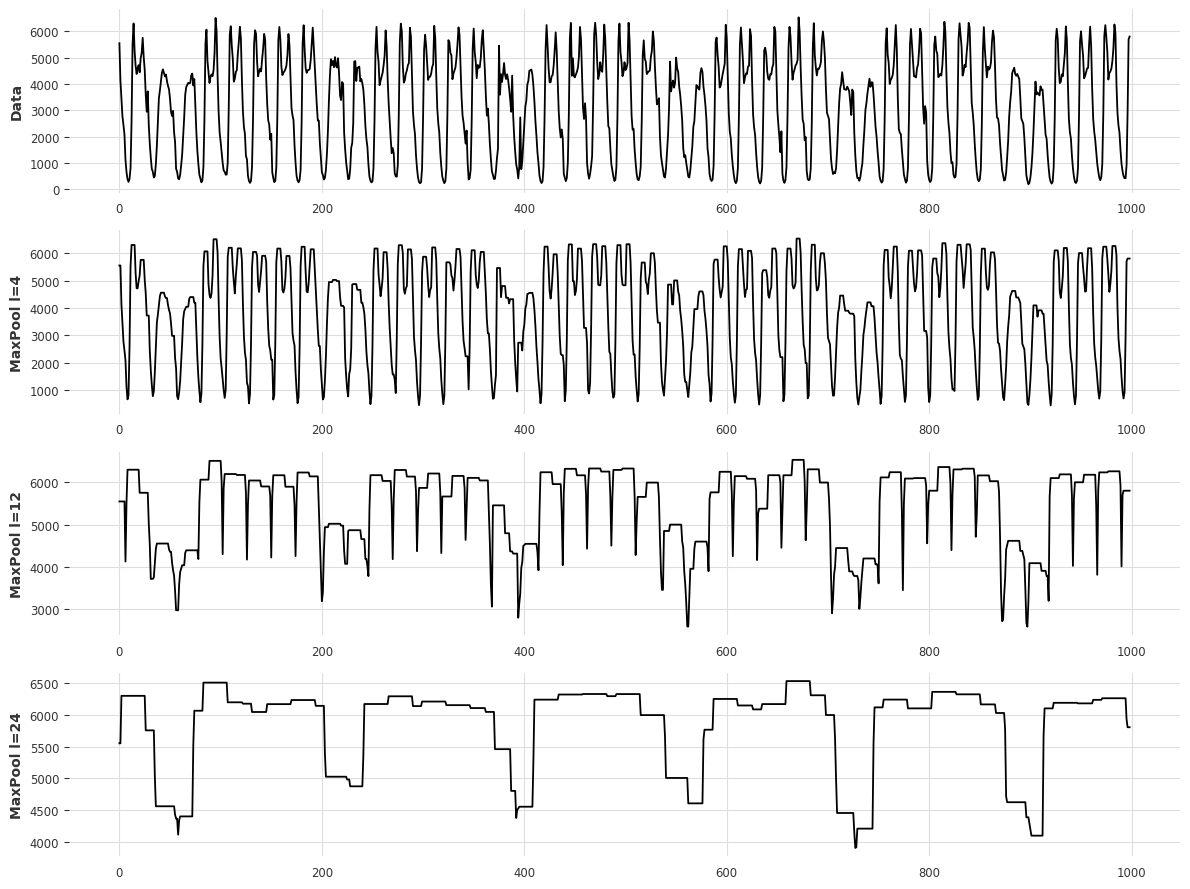

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(12,9))

ax1.plot(df['traffic_volume'])
ax1.set_ylabel('Data')

ax2.plot(x_maxpooled_l4)
ax2.set_ylabel('MaxPool l=4')

ax3.plot(x_maxpooled_l12)
ax3.set_ylabel('MaxPool l=12')

ax4.plot(x_maxpooled_l24)
ax4.set_ylabel('MaxPool l=24')

plt.tight_layout()

## Apply N-HiTS 

In [11]:
from darts.models import NHiTSModel
from darts.dataprocessing.transformers import Scaler

train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

nhits = NHiTSModel(
    input_chunk_length=168, 
    output_chunk_length=120,
    random_state=42)

nhits.fit(
    scaled_train,
    epochs=50)

scaled_pred_nhits = nhits.predict(n=120)
pred_nhits = train_scaler.inverse_transform(scaled_pred_nhits)

mae_nhits = mae(test, pred_nhits)

print(mae_nhits)

2022-11-27 18:27:46 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-11-27 18:27:46 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-27 18:27:46 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-27 18:27:46 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-27 18:27:46 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.1 M 
---------------------------------------------------
970 K     Trainable params
86.2 K    Non-trainable params
1.1 M     Total params
8.457     Total estimated model params size (MB)


Epoch 49: 100%|███████████████████████████████████████| 19/19 [00:00<00:00, 40.69it/s, loss=0.0033, train_loss=0.00337]

2022-11-27 18:28:09 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.67it/s]
266.32520849589866


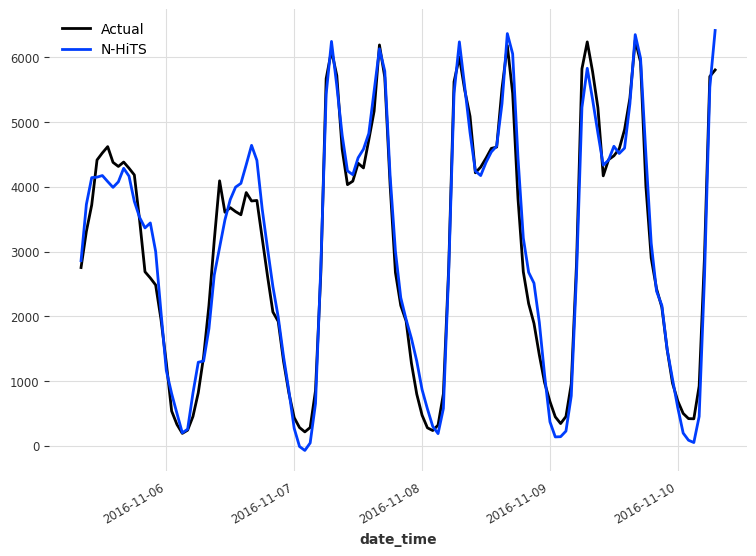

In [17]:
test.plot(label='Actual')
pred_nhits.plot(label='N-HiTS')

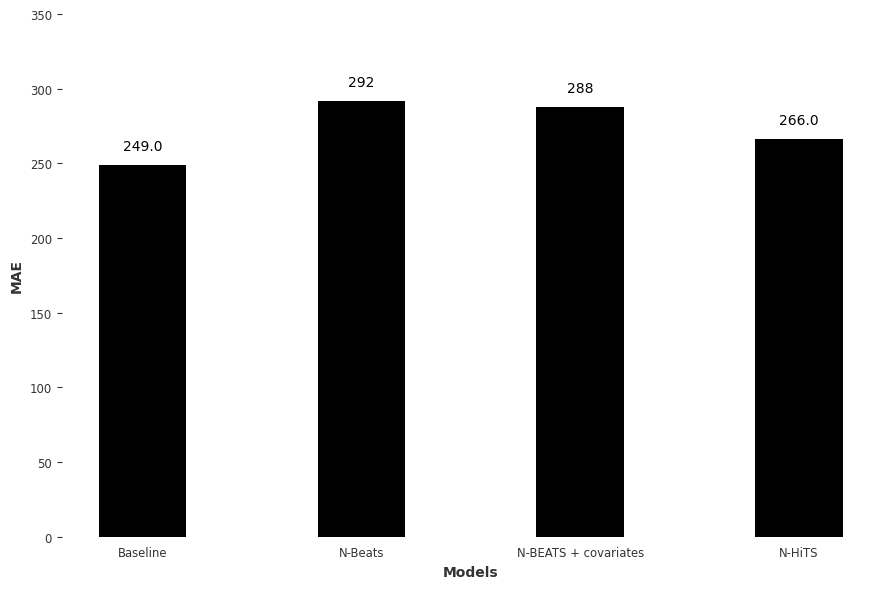

In [18]:
fig, ax = plt.subplots()

x = ['Baseline', 'N-Beats', 'N-BEATS + covariates', 'N-HiTS']
y = [naive_mae, 292, 288, mae_nhits]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.set_ylim(0, 350)
ax.grid(False)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 10, s=str(round(value,0)), ha='center')

plt.tight_layout()